In [ ]:
from pyscipopt import Model
from pyscipopt import quicksum as qsum
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def shortest_path(c: np.array):
    """
    c: np.array - distance matrix
    return: float, list - minimum cost and the shortest path
    """
    model = Model("Shortest Path")
    n = c.shape[0]
    start_node = 0
    end_node = n - 1

    # Decision Variable
    x = {
        (i, j): model.addVar(vtype="B", name=f"x{i}_{j}")
        for i in range(n)
        for j in range(n)
    }
    # Objective Function
    model.setObjective(
        qsum(c[i, j] * x[i, j] for i in range(n) for j in range(n) if i != j),
        "minimize",
    )

    # Flow conservation constraint

    # Start node
    model.addCons(
        qsum(x[start_node, j] for j in range(n) if j != start_node)
        - qsum(x[j, start_node] for j in range(n) if j != start_node)
        == 1
    )
    # End node:
    model.addCons(
        qsum(x[end_node, j] for j in range(n) if j != end_node)
        - qsum(x[j, end_node] for j in range(n) if j != end_node)
        == -1
    )
    # Each other node
    for i in range(1, n - 1):
        model.addCons(
            qsum(x[i, j] for j in range(n) if j != i)
            - qsum(x[j, i] for j in range(n) if j != i)
            == 0
        )

    # outgoing flow constraint
    for i in range(n):
        model.addCons(qsum(x[i, j] for j in range(n) if j != i) <= 1)

    model.hideOutput()
    model.optimize()
    min_cost = model.getObjVal()
    x_val = {
        (i, j): model.getVal(x[i, j])
        for i in range(n)
        for j in range(n)
        if model.getVal(x[i, j]) > 0.5
    }
    tour = [start_node] + [k[1] for k in sorted(x_val.keys())]

    return min_cost, tour

In [308]:
def plot_tour(points: np.array, tour: np.array):
    """
    points: np.array - list of points
    tour: np.array - list of tour
    """
    n = points.shape[0]
    # add first point to the end
    # create axis
    fig, ax = plt.subplots()
    # plot tour
    ax.plot(
        points[tour, 0], points[tour, 1], color="#202020", linestyle="-", linewidth=1
    )

    for i in range(n):
        for j in range(n):
            if i != j and j not in tour:
                ax.plot(
                    [points[i, 0], points[j, 0]],
                    [points[i, 1], points[j, 1]],
                    color="#624d6b",
                    linestyle="--",
                    linewidth=0.6,
                )
                ax.annotate(
                    str(np.round(np.linalg.norm(points[i] - points[j]), 2)),
                    (points[i] + points[j]) / 2,
                    color="#624d6b",
                    fontsize=8,
                    ha="center",
                    va="center",
                )
    # plot points
    ax.plot(
        points[:, 0],
        points[:, 1],
        "o",
        color="#624d6b",
        markersize=13,
        markeredgewidth=1,
        markeredgecolor="#202020",
    )
    for i in range(n):
        ax.annotate(
            str(i),
            (points[i, 0], points[i, 1]),
            color="white",
            weight="bold",
            fontsize=8,
            ha="center",
            va="center",
        )
    plt.show()

In [291]:
def make_random_instance(n: int, complete: bool = False):
    """
    n: int - number of points
    return: tuple - (points: np.array, c: np.array)
    """
    # list of random points
    points = np.random.rand(n, 2)
    # cost matrix with Euclidean distance
    c = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            c[i, j] = np.linalg.norm(points[i] - points[j])
    return points, c

Minimum cost: 0.45091360093655874, x_val: [0, 2, 4]


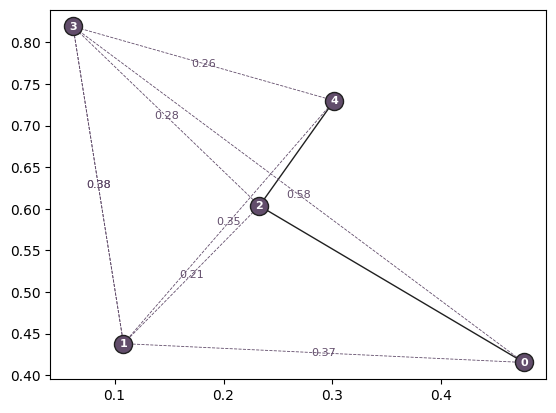

In [318]:
if __name__ == "__main__":
    points, c = make_random_instance(5)
    c[0, 4] = 1
    c[4, 0] = 1
    min_cost, tour = shortest_path(c)
    print(f"Minimum cost: {min_cost}, x_val: {tour}")
    plot_tour(points, tour)